In [1]:
import re

layer_re = re.compile(
    r"INFO layer (\d+?) iter (\d+?) loss:(nan|[\.\d]+?) norm:(nan|[\.\d]+?) max memory_allocated ([\.\d]+)")
task_re = re.compile(r"INFO \{'results': (.+?), 'versions'")
ppl_re = re.compile(r"INFO (wikitext2|(?:ptb|c4)(?:-new)?) : ([\.\d]+)")


test_layer_re = "[2025-03-11 17:27:43 root] (RLQuant.py 236): INFO layer 0 iter 0 loss:0.023954108357429504 norm:0.28997743129730225 max memory_allocated 16404.5771484375 \n"
print(layer_re.search(test_layer_re).groups())

test_task_re = "[2025-03-10 14:06:13 root] (main.py 197): INFO {'results': {'arc_challenge': {'acc': 0.2977815699658703, 'acc_stderr': 0.013363080107244484, 'acc_norm': 0.31313993174061433, 'acc_norm_stderr': 0.013552671543623504}, 'piqa': {'acc': 0.7230685527747551, 'acc_stderr': 0.010440499969334526, 'acc_norm': 0.720348204570185, 'acc_norm_stderr': 0.010471899530306555}, 'arc_easy': {'acc': 0.5618686868686869, 'acc_stderr': 0.010180937100600083, 'acc_norm': 0.44991582491582494, 'acc_norm_stderr': 0.010208181969301795}, 'winogrande': {'acc': 0.6029992107340174, 'acc_stderr': 0.013751092519806704}, 'boolq': {'acc': 0.6385321100917432, 'acc_stderr': 0.008402698339957966}, 'hellaswag': {'acc': 0.4592710615415256, 'acc_stderr': 0.004973199296339969, 'acc_norm': 0.5995817566221868, 'acc_norm_stderr': 0.004889817489739683}}, 'versions': {'arc_challenge': 0, 'piqa': 0, 'arc_easy': 0, 'winogrande': 0, 'boolq': 1, 'hellaswag': 0}, 'config': {'model': <models.LMClass.LMClass object at 0x7940c21b9db0>, 'model_args': None, 'num_fewshot': 0, 'limit': None, 'bootstrap_iters': 100000, 'description_dict': None}}"
test_task_re_result = task_re.search(test_task_re).groups()[0]
print(eval(test_task_re_result))

test_ppl_re = "[2025-03-17 09:45:40 root] (main.py 186): INFO wikitext2 : 12.18686580657959"
print(ppl_re.search(test_ppl_re).groups())

('0', '0', '0.023954108357429504', '0.28997743129730225', '16404.5771484375')
{'arc_challenge': {'acc': 0.2977815699658703, 'acc_stderr': 0.013363080107244484, 'acc_norm': 0.31313993174061433, 'acc_norm_stderr': 0.013552671543623504}, 'piqa': {'acc': 0.7230685527747551, 'acc_stderr': 0.010440499969334526, 'acc_norm': 0.720348204570185, 'acc_norm_stderr': 0.010471899530306555}, 'arc_easy': {'acc': 0.5618686868686869, 'acc_stderr': 0.010180937100600083, 'acc_norm': 0.44991582491582494, 'acc_norm_stderr': 0.010208181969301795}, 'winogrande': {'acc': 0.6029992107340174, 'acc_stderr': 0.013751092519806704}, 'boolq': {'acc': 0.6385321100917432, 'acc_stderr': 0.008402698339957966}, 'hellaswag': {'acc': 0.4592710615415256, 'acc_stderr': 0.004973199296339969, 'acc_norm': 0.5995817566221868, 'acc_norm_stderr': 0.004889817489739683}}
('wikitext2', '12.18686580657959')


In [2]:
import os

results = {}

for model_name in os.listdir("../log"):
    model_path = os.path.join(os.getcwd(), "..", "log", model_name)

    for log_filename in os.listdir(model_path):
        if log_filename.endswith(".pth"):
            continue

        log_path = os.path.join(model_path, log_filename)
        print(f"processing file {log_path}")

        with open(log_path, "r") as log_file:
            while line := log_file.readline():
                if match_result := layer_re.search(line):
                    layer, iter, loss, norm, max_memory_allocated = match_result.groups()

                    model_loss_dict = results.setdefault(model_name, {"layers": [], "tasks": [], "ppl": []})
                    layers = model_loss_dict["layers"]
                    if len(layers) <= int(layer):
                        layers.append([])
                    layers[int(layer)].append((loss, norm, max_memory_allocated))
                elif match_result := task_re.search(line):
                    task_result = eval(match_result.groups()[0])

                    model_loss_dict = results.setdefault(model_name, {"layers": [], "tasks": [], "ppl": []})
                    model_loss_dict["tasks"].append(task_result)
                elif match_result := ppl_re.search(line):
                    ppl_dataset, value = match_result.groups()

                    model_loss_dict = results.setdefault(model_name, {"layers": [], "tasks": [], "ppl": []})
                    model_loss_dict["ppl"].append((ppl_dataset, float(value)))

print(results)
                    

processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-lr.25-nlc4-ep1/log_rank0_1741975804.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-lr.25-nlc4-ep1/log_rank0_1742062326.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-nlc4/log_rank0_1741608040.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-nlc4/log_rank0_1741665485.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-lr.5-nlc4/log_rank0_1742155505.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-lr.5-nlc4/log_rank0_1742140434.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-lr.5-nlc4-ep1/log_rank0_1741974247.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-lr.5-nlc4-ep1/log_rank0_1742060086.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-

In [3]:
model_name_prefix = "llama-2-7b-hf-w4a4-"

task_model_dict = {}
for key, item in sorted(results.items()):
    if not "tasks" in item or len(item["tasks"]) == 0: continue
    
    tasks = item["tasks"][0]
    for task_name, task_result in sorted(tasks.items()):
        if not task_name in task_model_dict:
            task_model_dict.setdefault(task_name, [])

        task_model_dict[task_name].append((key[len(model_name_prefix):], task_result['acc']))

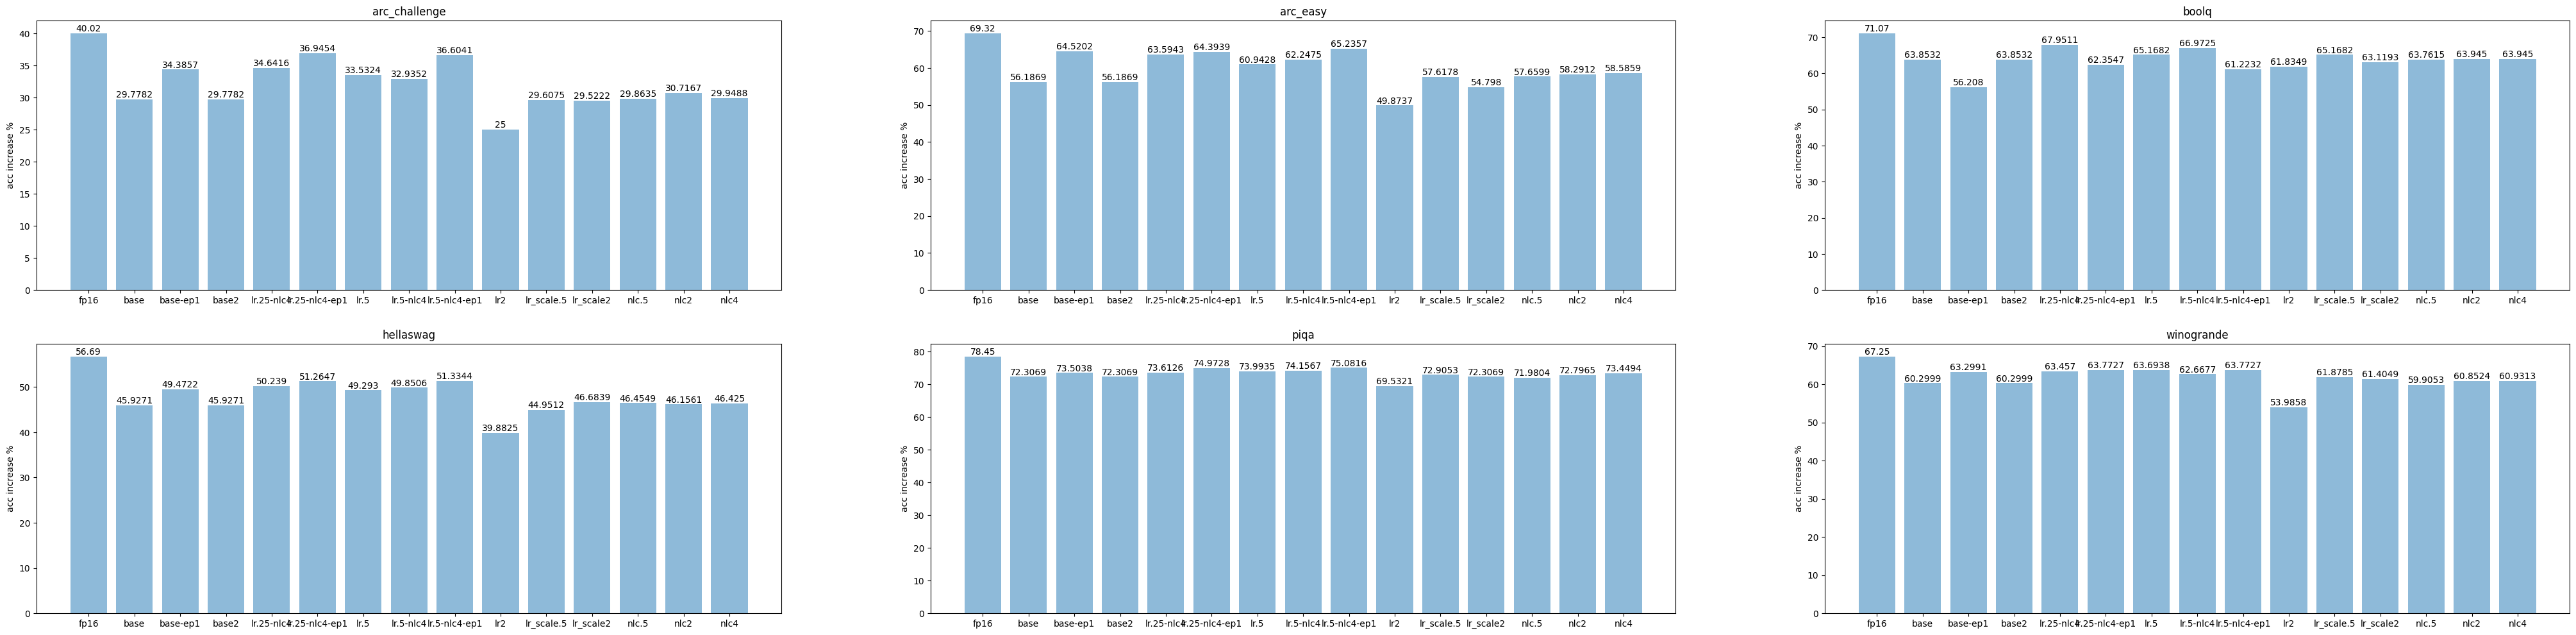

In [4]:
import matplotlib.pyplot as plt
import numpy as np

task_ignore_models = [
    # "base",
    "lr4",
]
fp_16_results = {
    "piqa": 0.7845,
    "arc_easy": 0.6932,
    "arc_challenge": 0.4002,
    "boolq": 0.7107,
    "hellaswag": 0.5669,
    "winogrande": 0.6725,
}
# base_results = {
#     "piqa": 0.6371,
#     "arc_easy": 0.4696,
#     "arc_challenge": 0.2627,
#     "boolq": 0.6339,
#     "hellaswag": 0.4442,
#     "winogrande": 0.5319
# }

fig = plt.figure(figsize=(len(results)*len(task_model_dict)//2, 12))

for idx, (task, model_result) in enumerate(task_model_dict.items()):
    ax = fig.add_subplot(2, len(task_model_dict)//2, (idx+1))
    ax.set_title(task)
    ax.set_ylabel("acc increase %")

    base_result = next(
        (value for name, value in model_result if name == "base"), None)
    if base_result is None:
        raise KeyError("cannot find base result")
    model_result = [("fp16", fp_16_results[task]), *model_result]
    # base_result = base_results[task]
    names, values = zip(*((name, value) for name,
                        value in model_result if name not in task_ignore_models))
    values = np.array(values)

    rect = ax.bar(names, (values)*100, align='center', alpha=0.5)
    ax.bar_label(rect)

plt.show()

5
[('base', 12.936057090759277), ('base-ep1', 23.896516799926758), ('base2', 17.238595962524414), ('lnl', 16.07359504699707), ('lr.25-nlc4', 14.971124649047852), ('lr.25-nlc4-ep1', 33.65837860107422), ('lr.5', 15.308334350585938), ('lr.5-nlc4', 15.64964485168457), ('lr.5-nlc4-ep1', 31.682024002075195), ('lr2', 17.39445686340332), ('lr4', 17.808244705200195), ('lr_scale.5', 15.959525108337402), ('lr_scale2', 17.96435546875), ('nlc.5', 17.330476760864258), ('nlc2', 16.621572494506836), ('nlc4', 18268.94140625)]
[('base', 14.785731315612793), ('base-ep1', 25.69214630126953), ('base2', 19.25412940979004), ('lnl', 17.780109405517578), ('lr.25-nlc4', 16.670944213867188), ('lr.25-nlc4-ep1', 36.12215805053711), ('lr.5', 17.056293487548828), ('lr.5-nlc4', 17.428396224975586), ('lr.5-nlc4-ep1', 33.94023132324219), ('lr2', 19.219566345214844), ('lr4', 19.424694061279297), ('lr_scale.5', 17.56163787841797), ('lr_scale2', 19.27735137939453), ('nlc.5', 19.058324813842773), ('nlc2', 18.21786880493164

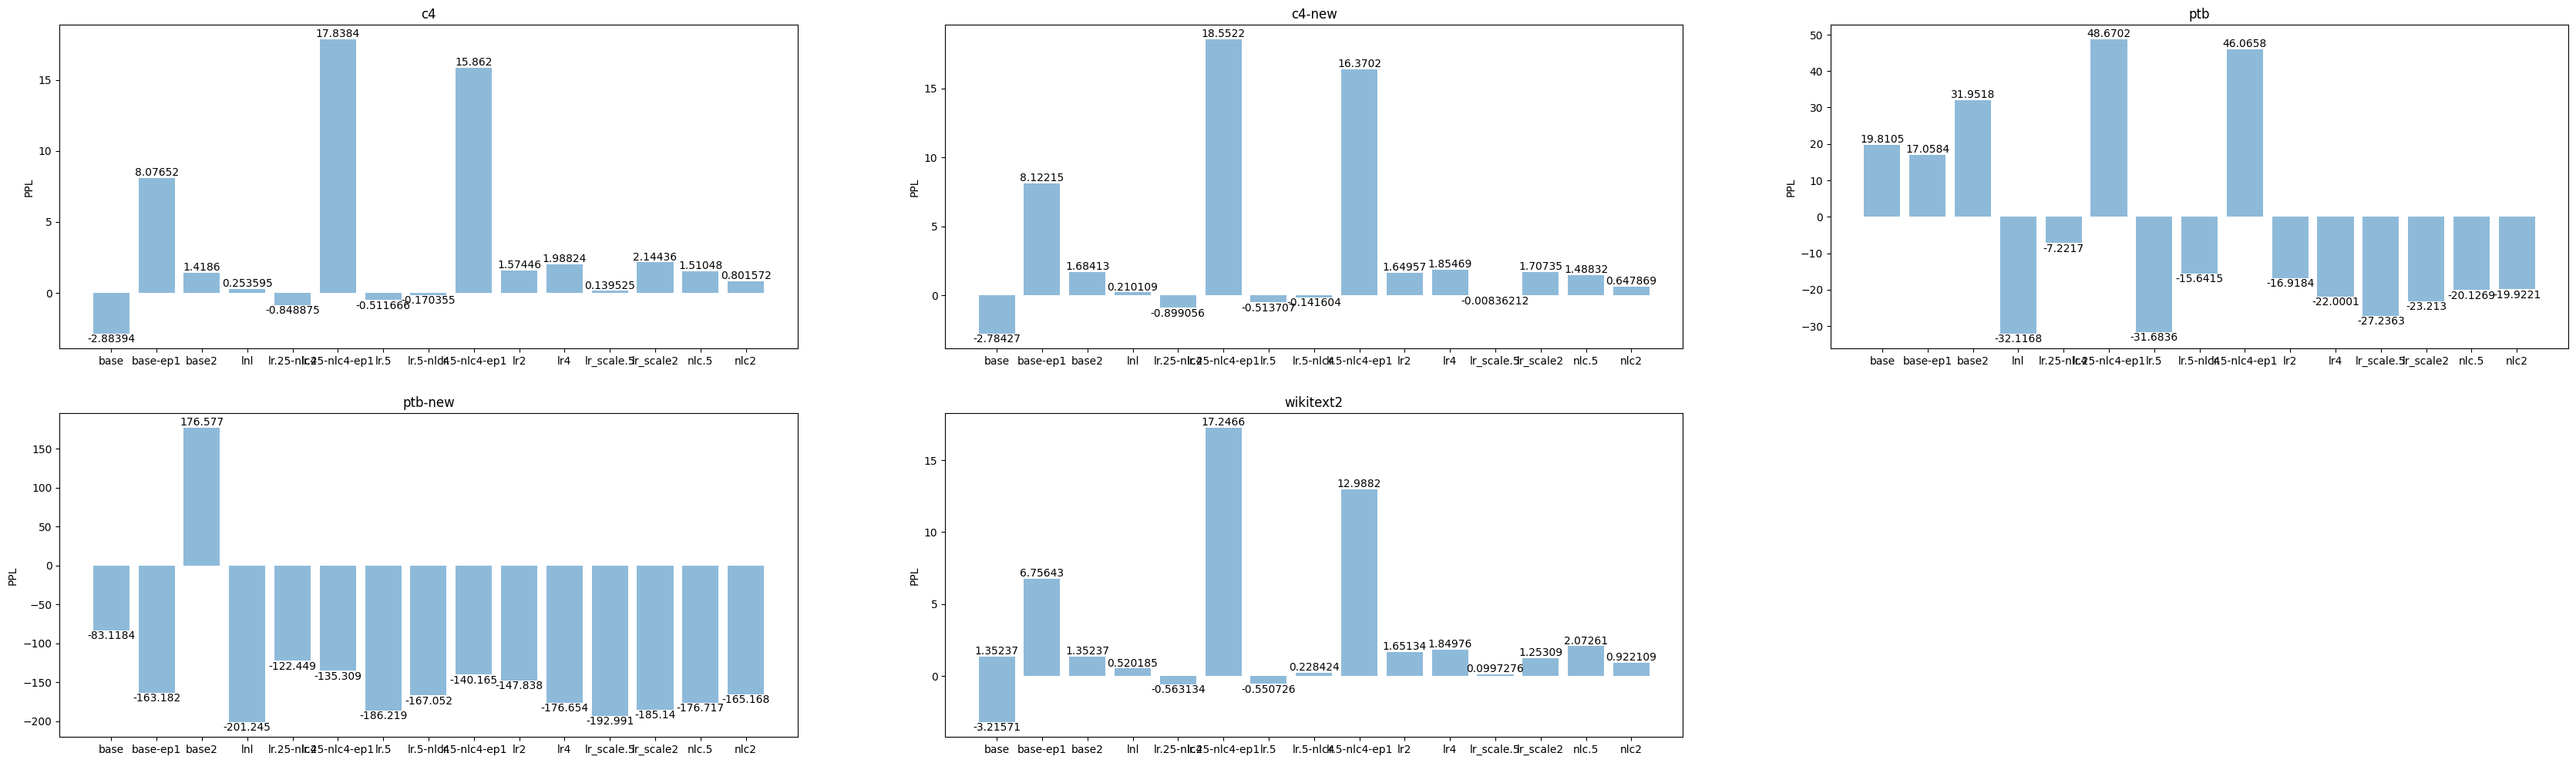

In [10]:
ppl_model_dict = {}
for key, item in sorted(results.items()):
    if not "ppl" in item or len(item["ppl"]) == 0:
        continue

    ppl = item["ppl"]
    for ppl_name, ppl_result in sorted(ppl, key=lambda x: x[0]):
        if not ppl_name in ppl_model_dict:
            ppl_model_dict.setdefault(ppl_name, [])

        ppl_model_dict[ppl_name].append(
            (key[len(model_name_prefix):], ppl_result))

print(len(ppl_model_dict))


ppl_ignore_models = [
    "nlc4",
]
base_results = {
    "wikitext2": 12.75,
    "ptb": 87.63,
    "c4": 15.82,
    "ptb-new": 281.41,
    "c4-new": 17.57
}

fig = plt.figure(figsize=(len(results)*len(ppl_model_dict)//2, 12))

for idx, (ppl_name, model_result) in enumerate(ppl_model_dict.items()):
    ax = fig.add_subplot(2, (len(ppl_model_dict)+1)//2, (idx+1))
    ax.set_title(ppl_name)
    ax.set_ylabel("PPL")

    print(model_result)
    # base_result = next((value for name, value in model_result if name == "base"), None)
    # if base_result is None: raise KeyError(f"cannot find base result for ppl {ppl_name}")
    base_result = base_results[ppl_name]
    names, values = zip(*((name, value) for name,
                        value in model_result if name not in ppl_ignore_models))
    values = np.array(values)

    rect = ax.bar(names, values - base_result, align='center', alpha=0.5)
    ax.bar_label(rect)

plt.show()